# Water Table

- `amount_tsh` - Общий статический напор (количество воды, доступное для водоразборной точки)
- `date_recorded` - Дата создания строки
- `funder` - Кто финансировал скважину
- `gps_height` - Высота скважины
- `installer` - Организация, установившая скважину
- `longitude` - GPS-координаты (долгота)
- `latitude` - GPS-координаты (широта)
- `wpt_name` - Название водозаборной точки, если таковая имеется
- `num_private` -
- `basin` - Географический водный бассейн
- `subvillage` - Поселок
- `region` - Регион
- `region_code` - Код региона
- `district_code` - Код района
- `lga` - Географическое положение
- `ward` - Географическое положение
- `population` - Население вокруг скважины
- `public_meeting` - True/False
- `recorded_by` - Группа, которая создала запись о скважине
- `scheme_management` - Кто управляет пунктом водоразбора
- `scheme_name` - Кто управляет пунктом водоразбора
- `permit` - Если водозабор разрешен
- `construction_year` - Год постройки водонапорной точки
- `extraction_type` - Вид извлечения, используемый в точке водозабора
- `extraction_type_group` - Вид извлечения, используемый в точке водозабора
- `extraction_type_class` - Вид извлечения, используемый в точке водозабора
- `management` - Как управляется точка водозабора
- `management_group` - Как управляется точка водозабора
- `payment` - Сколько стоит вода
- `payment_type` - Сколько стоит вода
- `water_quality` - Качество воды
- `quality_group` - Качество воды
- `quantity` - Количество воды
- `quantity_group` - Количество воды
- `source` - Источник воды
- `source_type` - Источник воды
- `source_class` - Источник воды
- `waterpoint_type` - Вид водозабора
- `waterpoint_type_group` - Вид водозабора

In [58]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

from catboost import CatBoostClassifier, Pool

from h2o.sklearn import H2OAutoMLClassifier

In [2]:
SEED = 42

In [29]:
train = pd.read_csv("train.csv")
target = pd.read_csv("train_labels.csv")

In [30]:
train.shape

(59400, 40)

In [31]:
train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [32]:
target.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


<AxesSubplot: >

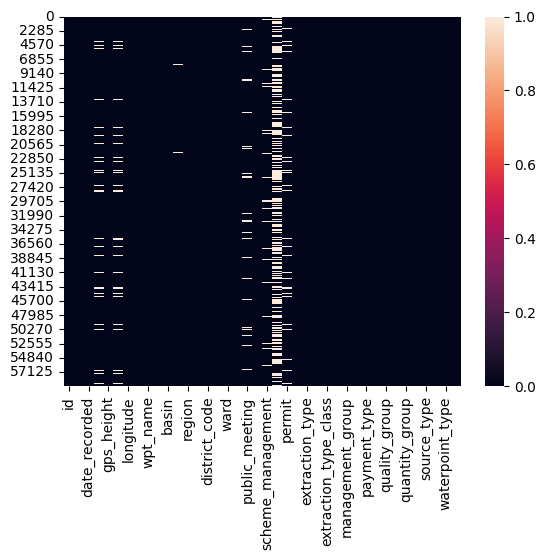

In [33]:
sns.heatmap(train.isnull())

Так как мы имеем дело с данными, которые требует достоверности, то мы не можем заполнять пропуски основываясь на статистических или модельный методах, так как, если данные для признакак объекта не были указаны, то значит объект не принадлежал популярным значениям в признаки. То ест пропущенные значение вероятно будут заполнены популярными значениям признака, что с большей вероятностью не будет верно.

In [34]:
null_cols = []
for col in train.isnull().columns:
    if len(train[col][pd.isna(train[col])])/len(train) > 0:
        null_cols.append(col)

# null_cols
train.drop(columns=null_cols, inplace=True, axis=1)

Пропишим категориальные и числовые признаки, отобрав только те, которы не зависят от географического, именного и подобных положений

In [35]:
cat_cols = ["extraction_type", "extraction_type_group",
            "extraction_type_class", "payment_type", "water_quality", "quality_group",
            "source", "source_type", "source_class", "waterpoint_type", "waterpoint_type_group",
            "payment", "quantity", "quantity_group"]

num_cols = ["amount_tsh", "gps_height", "num_private", "population", "construction_year"]

id_col = ["id"]

Удалим строки, где неизвестна дата постройки скважины, так как год постройки один из признаков, который может указать на то, что нужно проверить, функционирует ли сважина

In [36]:
train = train.where(train["construction_year"] > 0 ).dropna(axis=0)
train.reset_index(inplace=True, drop=True)

<AxesSubplot: >

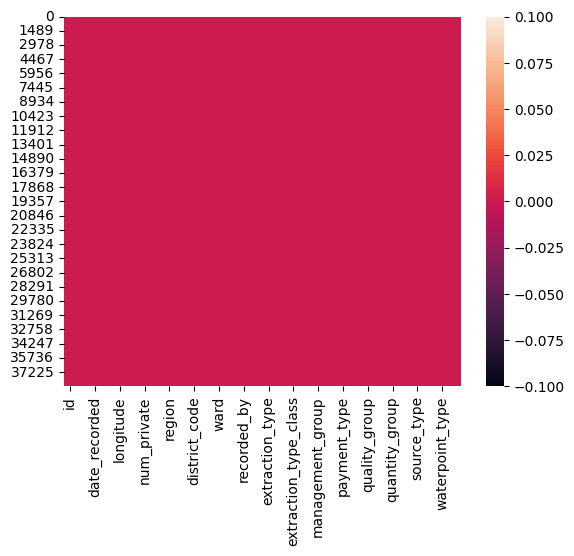

In [37]:
sns.heatmap(train.isnull())

Закодируем целевой признак

In [38]:
le_target = LabelEncoder()

target["target"] = le_target.fit_transform(target["status_group"])

При помощи OneHotEncoder закодируем категориальные признаки

In [41]:
ohe = OneHotEncoder(sparse_output=False)

train_cat_ohe = ohe.fit_transform(train[cat_cols])

cols_cats = []

for cat in ohe.categories_:
    cols_cats.extend(cat)

train_cat_ohe = pd.DataFrame(train_cat_ohe)
train_cat_ohe.reset_index(inplace=True, drop=True)

Объединим числовые и закодированные, категориальные признаки

In [43]:
train = pd.concat([train[id_col], train[num_cols], train_cat_ohe], axis=1)

Стандартизируем числовые признаки

In [44]:
scaler = StandardScaler()

train[num_cols] = scaler.fit_transform(train[num_cols])

Отсавим в таргете id, которые есть в train

In [45]:
target_ids = [id.tolist()[0] for id in target[id_col].values if id in train[id_col].values]

In [46]:
target["id_flag"] = target[id_col].isin(target_ids)

In [47]:
target.where(target["id_flag"] == True, axis=0, inplace=True)
target.dropna(inplace=True, axis=0)

C:\Users\Vasily\AppData\Local\Temp\ipykernel_27248\91529409.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  target.where(target["id_flag"] == True, axis=0, inplace=True)


In [48]:
target

,id,status_group,target,id_flag
0,69572.0,functional,0.0,True
1,8776.0,functional,0.0,True
2,34310.0,functional,0.0,True
3,67743.0,non functional,2.0,True
5,9944.0,functional,0.0,True
...,...,...,...,...
59391,44885.0,non functional,2.0,True
59394,11164.0,non functional,2.0,True
59395,60739.0,functional,0.0,True
59396,27263.0,functional,0.0,True


In [49]:
train

,id,amount_tsh,gps_height,num_private,population,construction_year,0,1,2,3,...,99,100,101,102,103,104,105,106,107,108
0,69572.0,1.562710,0.627165,-0.046919,-0.291126,0.175219,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,8776.0,-0.131731,0.641726,-0.046919,0.018468,1.057203,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,34310.0,-0.124671,-0.511863,-0.046919,-0.035847,0.977023,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,67743.0,-0.131731,-1.196251,-0.046919,-0.383461,-0.867125,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,9944.0,-0.126083,-1.621769,-0.046919,-0.486659,0.977023,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38686,44885.0,-0.131731,-0.748082,-0.046919,-0.108267,-2.390552,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
38687,11164.0,0.009473,-1.053873,-0.046919,-0.327336,0.816662,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
38688,60739.0,-0.128907,0.335936,-0.046919,-0.262158,0.175219,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
38689,27263.0,1.195582,0.339172,-0.046919,-0.387082,-0.065322,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Train, Test

In [50]:
X_train, X_test, y_train, y_test = train_test_split(train, target["target"], test_size=0.15, random_state=SEED, stratify=target["target"])

## AutoML

In [56]:
h2o = H2OAutoMLClassifier(max_models=20, seed=SEED, max_runtime_secs=900, balance_classes=True, sort_metric="logloss")

h2o.fit(X_train, pd.DataFrame(y_train)) 

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
12:52:03.680: AutoML: XGBoost is not available; skipping it.


12:52:05.424: GLM_1_AutoML_1_20250216_125203 [GLM def_1] failed: java.lang.ArrayIndexOutOfBoundsException: 114

███████████████████████████████████████████████████████████████| (done) 100%


H2OAutoMLClassifier(balance_classes=True, max_models=20, max_runtime_secs=900,
                    seed=42, sort_metric='logloss')

In [100]:
y_pred = h2o.predict_proba(X_test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


c:\Users\Vasily\anaconda3\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [102]:
print(f"LogLoss on test: {log_loss(y_test.to_list(), list(y_pred))}")

LogLoss on test: 0.5178312069919607


## CatBoost

In [103]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=SEED, stratify=y_train)

In [105]:
cat_clf = CatBoostClassifier(eval_metric="MultiClass")

train_pool = Pool(X_train, y_train)
val_pool = Pool(X_val, y_val)
test_pool = Pool(X_test, y_test)

cat_clf.fit(train_pool, use_best_model=True, eval_set=val_pool, verbose=2)

Learning rate set to 0.115274
0:	learn: 1.0092737	test: 1.0089096	best: 1.0089096 (0)	total: 11.3ms	remaining: 11.3s
2:	learn: 0.8932866	test: 0.8929976	best: 0.8929976 (2)	total: 32ms	remaining: 10.6s
4:	learn: 0.8228053	test: 0.8225066	best: 0.8225066 (4)	total: 51.2ms	remaining: 10.2s
6:	learn: 0.7705180	test: 0.7700739	best: 0.7700739 (6)	total: 72ms	remaining: 10.2s
8:	learn: 0.7353407	test: 0.7350522	best: 0.7350522 (8)	total: 91.3ms	remaining: 10.1s
10:	learn: 0.7097297	test: 0.7095638	best: 0.7095638 (10)	total: 113ms	remaining: 10.1s
12:	learn: 0.6895671	test: 0.6901408	best: 0.6901408 (12)	total: 134ms	remaining: 10.1s
14:	learn: 0.6742652	test: 0.6753968	best: 0.6753968 (14)	total: 155ms	remaining: 10.2s
16:	learn: 0.6627417	test: 0.6644802	best: 0.6644802 (16)	total: 176ms	remaining: 10.2s
18:	learn: 0.6536954	test: 0.6563012	best: 0.6563012 (18)	total: 198ms	remaining: 10.2s
20:	learn: 0.6450454	test: 0.6483899	best: 0.6483899 (20)	total: 222ms	remaining: 10.4s
22:	learn: 

In [106]:
y_pred = cat_clf.predict_proba(X_test)
print(f"LogLoss on test: {log_loss(y_test.to_list(), list(y_pred))}")

LogLoss on test: 0.5240557387681819


## Вывод

AutoML показал немного лучше результат, чем CatBoost из коробки. В целом AutoML очень полезен, чтобы изучить, какие результаты выдают различные модели, но тоже требует предварительной настройки, даже можно добить и еще высокого качества.

В целом, мне кажется AutoML - очень крутая вещь, особенно в оптимизации гиперпараметров справляется лучше человека.